<a href="https://colab.research.google.com/github/gabrielmprata/acidentes_transito/blob/main/Acidentes_Rodoviarios_PreProc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img loading="lazy" src="https://cdn.jsdelivr.net/gh/devicons/devicon@latest/icons/python/python-original.svg" width="40" height="40"/> <img src="https://cdn.jsdelivr.net/gh/devicons/devicon@latest/icons/pandas/pandas-original-wordmark.svg" width="40" height="40"/>   <img loading="lazy" src="https://cdn.jsdelivr.net/gh/devicons/devicon@latest/icons/plotly/plotly-original-wordmark.svg" width="40" height="40"/>

---
**Pré Processamento de dados**
>
**Dev**: Gabriel Prata
>
**Data**: 06/03/2025
>
**Última modificação**: 23/03/2025
>
**Contexto**: *Dados abertos de acidentes de trânsito*
>
---

![Badge em Desenvolvimento](http://img.shields.io/static/v1?label=STATUS&message=EM%20DESENVOLVIMENTO&color=GREEN&style=for-the-badge)

![Badge versao](http://img.shields.io/static/v1?label=Ver.&message=v1.0&color=red&style=for-the-badge&logo=github)

#**<font color=#4c60d6 size="6"> Import libraries**

In [1]:
# Importação de pacotes
import pandas as pd
import numpy as np
import missingno as ms # para tratamento de missings
import datetime
import re # expressão regulares
from random import randint # gerar inteiros aliatórios

#bibliotecas para visualização de dados
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

#importar a biblioteca para usar a Distribuição Binomial de Bernoulli
from scipy.stats import bernoulli

#compactar
from shutil import copyfileobj
import bz2

# Configuração para não exibir os warnings
import warnings
warnings.filterwarnings("ignore")

#**<font color=#4c60d6 size="6"> 1. Objetivo**

Esse Notebook, foca na etapa de pré-processamento de dados.
>
Esta é a etapa mais demorada e trabalhosa do projeto de ciência de dados, e estima-se que consuma pelo menos 70% do tempo total do projeto.
>
Ao final desse notebook, entregaremos um arquivo mais coeso para as análises dos dados de acidentes de trânsito, nas rodovias federais brasileiras.

#**<font color=#4c60d6 size="6"> 2. Coleta de dados**

Os dados foram coletados do sítio da Polícia Rodoviária Federal.
<img align="left" width="80" height="94" src="https://github.com/gabrielmprata/MVP_Sprint01_Puc_Rio/assets/119508139/f9646e84-d274-406b-9a7a-12add19acb07">
>
https://www.gov.br/prf/pt-br/acesso-a-informacao/dados-abertos/dados-abertos-acidentes
>

###**<font color=#4c60d6> 2.1 Acidentes por ocorrência**

In [2]:
# importando dataset

# URL de importação
url   = "https://raw.githubusercontent.com/gabrielmprata/acidentes_transito/main/datasets/datatran2024.zip"

url2  = "https://raw.githubusercontent.com/gabrielmprata/acidentes_transito/main/datasets/datatran2023.zip"

df_acidentes = pd.read_csv(url, compression='zip', encoding = "Latin 1", delimiter=';')

# 2023 somente para comparativo
df_acidentes_2023 = pd.read_csv(url2, compression='zip', encoding = "Latin 1", delimiter=';')

###**<font color=#4c60d6> 2.2 Pessoas envolvidas**

In [3]:
url3   = "https://raw.githubusercontent.com/gabrielmprata/acidentes_transito/main/datasets/acidentes2024.csv.bz2"

df_pessoas = pd.read_csv(url3, compression='bz2', encoding = "Latin 1", delimiter=';')

###**<font color=#4c60d6> 2.3 Região IBGE**

Iremos utilizar a API do IBGE, para coletar informações, que irão enriquecer o Dataset com o nome estado e a região.

In [4]:
pip install ibge

In [5]:
# Importando os pacotes da biblioteca de localidades
from ibge.localidades import *

In [6]:
# Função Estados() retorna um objeto do tipo ibge.localidades.Estados
dados = Estados()
#dados = Municipios()

In [7]:
type(dados)

ibge.localidades.Estados

In [8]:
regiao = dados.json()

In [9]:
#pandas json_normalize ler a string JSON aninhada e devolver um DataFrame.
estados_br = pd.json_normalize(regiao)

In [10]:
estados_br.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27 entries, 0 to 26
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            27 non-null     int64 
 1   sigla         27 non-null     object
 2   nome          27 non-null     object
 3   regiao.id     27 non-null     int64 
 4   regiao.sigla  27 non-null     object
 5   regiao.nome   27 non-null     object
dtypes: int64(2), object(4)
memory usage: 1.4+ KB


In [11]:
# Criar um data frame com as colunas que iremos utilizar
tb_regiao = estados_br[['sigla',
                            'nome',
                            'regiao.nome'
                          ]]

In [12]:
#renomear colunas
tb_regiao = tb_regiao.rename(columns={'sigla': 'uf',
                                      'nome': 'uf_nome',
                                'regiao.nome': 'regiao'
                                })

#**<font color=#4c60d6 size="6"> 3.1 Análise inicial do DataFrame: DataTran**

###**<font color=#4c60d6> 3.1.1 Estatísticas Descritivas**

In [13]:
#	Quantidade de atributos e instâncias (linhas/colunas)
df_acidentes.shape

(73156, 30)



---



In [14]:
# Exibir os 5 primeiros registros
df_acidentes.head(5)

,id,data_inversa,dia_semana,horario,uf,br,km,municipio,causa_acidente,tipo_acidente,...,feridos_graves,ilesos,ignorados,feridos,veiculos,latitude,longitude,regional,delegacia,uop
0,571789.0,2024-01-01,segunda-feira,03:56:00,ES,101,38,CONCEICAO DA BARRA,Ultrapassagem Indevida,Colisão lateral sentido oposto,...,1,1,1,1,3,-18.482610,-39.923790,SPRF-ES,DEL04-ES,UOP02-DEL04-ES
1,571804.0,2024-01-01,segunda-feira,04:50:00,PI,343,185,PIRIPIRI,Manobra de mudança de faixa,Colisão frontal,...,0,1,0,0,2,-4.296033,-41.767327,SPRF-PI,DEL02-PI,UOP01-DEL02-PI
2,571806.0,2024-01-01,segunda-feira,04:30:00,BA,116,578,BREJOES,Ingestão de álcool pelo condutor,Colisão frontal,...,0,1,2,0,4,-13.071583,-39.961111,SPRF-BA,DEL03-BA,UOP02-DEL03-BA
3,571818.0,2024-01-01,segunda-feira,06:30:00,SE,101,18,MALHADA DOS BOIS,Reação tardia ou ineficiente do condutor,Saída de leito carroçável,...,1,0,2,1,3,-10.356019,-36.905522,SPRF-SE,DEL02-SE,UOP02-DEL02-SE
4,571838.0,2024-01-01,segunda-feira,05:00:00,MT,364,240,RONDONOPOLIS,Condutor deixou de manter distância do veículo...,Colisão traseira,...,0,2,1,0,3,-16.179141,-54.789053,SPRF-MT,DEL02-MT,UOP01-DEL02-MT




---



In [15]:
# Mostra diversas informações do Dataframe em um único comando, e exibir o uso de memória
df_acidentes.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73156 entries, 0 to 73155
Data columns (total 30 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      73156 non-null  float64
 1   data_inversa            73156 non-null  object 
 2   dia_semana              73156 non-null  object 
 3   horario                 73156 non-null  object 
 4   uf                      73156 non-null  object 
 5   br                      73156 non-null  int64  
 6   km                      73156 non-null  object 
 7   municipio               73156 non-null  object 
 8   causa_acidente          73156 non-null  object 
 9   tipo_acidente           73156 non-null  object 
 10  classificacao_acidente  73155 non-null  object 
 11  fase_dia                73156 non-null  object 
 12  sentido_via             73156 non-null  object 
 13  condicao_metereologica  73156 non-null  object 
 14  tipo_pista              73156 non-null



---



In [16]:
# Quantidade de valores únicos
df_acidentes.nunique()

,0
id,73156
data_inversa,366
dia_semana,7
horario,1415
uf,27
br,113
km,7683
municipio,1833
causa_acidente,69
tipo_acidente,17




---



In [17]:
# Quantidade de NaN/Missing/Nulls no dataframe
df_acidentes.isnull().sum()

,0
id,0
data_inversa,0
dia_semana,0
horario,0
uf,0
br,0
km,0
municipio,0
causa_acidente,0
tipo_acidente,0


In [18]:
# Quantidade de NaN/Missing/Nulls no dataframe
df_acidentes_2023.isnull().sum()

,0
id,0
data_inversa,0
dia_semana,0
horario,0
uf,0
br,0
km,0
municipio,0
causa_acidente,0
tipo_acidente,0




---



###**<font color=#4c60d6> 3.1.2 Distribuição dos atributos**

>Nessa etapa, iremos verificar a distribuição dos principais atributos. Para ver se existe a necessidade de tomar alguma ação de transformações na etapa de preparação de dados.


---

In [19]:
df_acidentes.describe().round(2)

,id,br,pessoas,mortos,feridos_leves,feridos_graves,ilesos,ignorados,feridos,veiculos,latitude,longitude
count,73156.00,73156.00,73156.00,73156.00,73156.00,73156.00,73156.00,73156.00,73156.00,73156.00,73156.00,73156.00
mean,613003.77,209.58,2.60,0.08,0.88,0.28,1.05,0.40,1.16,1.99,-18.81,-46.40
std,23344.41,128.82,2.23,0.37,1.13,0.64,1.75,0.82,1.25,1.08,7.72,6.21
min,571772.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,-33.68,-72.64
25%,593042.75,101.00,2.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,-25.10,-50.21
50%,613246.50,158.00,2.00,0.00,1.00,0.00,1.00,0.00,1.00,2.00,-20.41,-47.01
75%,633190.25,324.00,3.00,0.00,1.00,0.00,1.00,1.00,1.00,2.00,-12.59,-42.18
max,661607.00,495.00,93.00,37.00,83.00,35.00,78.00,33.00,84.00,26.00,4.45,-32.41


In [20]:
df_acidentes.dia_semana.value_counts() #quantidade

,count
dia_semana,
domingo,11741
sábado,11641
sexta-feira,11300
segunda-feira,10208
quinta-feira,9570
quarta-feira,9384
terça-feira,9312


In [21]:
df_acidentes.causa_acidente.value_counts() #quantidade

,count
causa_acidente,
Reação tardia ou ineficiente do condutor,10920
Ausência de reação do condutor,10664
Acessar a via sem observar a presença dos outros veículos,6958
Condutor deixou de manter distância do veículo da frente,4460
Velocidade Incompatível,4347
...,...
Restrição de visibilidade em curvas verticais,7
Faróis desregulados,5
Sistema de drenagem ineficiente,4


In [22]:
df_acidentes.tipo_acidente.value_counts() #quantidade

,count
tipo_acidente,
Colisão traseira,13960
Saída de leito carroçável,10827
Colisão transversal,9385
Colisão lateral mesmo sentido,7902
Tombamento,6442
Colisão com objeto,5118
Colisão frontal,4862
Queda de ocupante de veículo,3349
Atropelamento de Pedestre,3167


In [23]:
df_acidentes.classificacao_acidente.value_counts() #quantidade

,count
classificacao_acidente,
Com Vítimas Feridas,56154
Sem Vítimas,11779
Com Vítimas Fatais,5222


In [24]:
(df_acidentes.classificacao_acidente.value_counts(dropna=False, normalize=True)*100).round(1)

,proportion
classificacao_acidente,
Com Vítimas Feridas,76.8
Sem Vítimas,16.1
Com Vítimas Fatais,7.1
NaN,0.0


In [25]:
df_acidentes.condicao_metereologica.value_counts() #quantidade

,count
condicao_metereologica,
Céu Claro,46271
Nublado,11033
Chuva,7420
Sol,3959
Garoa/Chuvisco,2776
Ignorado,918
Nevoeiro/Neblina,657
Vento,119
Granizo,2


#**<font color=#4c60d6 size="6"> 3.2 Análise inicial do DataFrame: Pessoas Envolvidas**

###**<font color=#4c60d6> 3.2.1 Estatísticas Descritivas**

In [26]:
#	Quantidade de atributos e instâncias (linhas/colunas)
df_pessoas.shape

(196306, 35)

In [27]:
# Exibir os 5 primeiros registros
df_pessoas.head(5)

,id,pesid,data_inversa,dia_semana,horario,uf,br,km,municipio,causa_acidente,...,sexo,ilesos,feridos_leves,feridos_graves,mortos,latitude,longitude,regional,delegacia,uop
0,571789.0,1269011,2024-01-01,segunda-feira,03:56:00,ES,101,38,CONCEICAO DA BARRA,Ultrapassagem Indevida,...,Masculino,1,0,0,0,-18.482610,-39.923790,SPRF-ES,DEL04-ES,UOP02-DEL04-ES
1,571804.0,1269118,2024-01-01,segunda-feira,04:50:00,PI,343,185,PIRIPIRI,Manobra de mudança de faixa,...,Masculino,1,0,0,0,-4.296033,-41.767327,SPRF-PI,DEL02-PI,UOP01-DEL02-PI
2,571806.0,1269735,2024-01-01,segunda-feira,04:30:00,BA,116,578,BREJOES,Ingestão de álcool pelo condutor,...,Masculino,1,0,0,0,-13.071583,-39.961111,SPRF-BA,DEL03-BA,UOP02-DEL03-BA
3,571818.0,1269075,2024-01-01,segunda-feira,06:30:00,SE,101,18,MALHADA DOS BOIS,Reação tardia ou ineficiente do condutor,...,Masculino,0,0,1,0,-10.356019,-36.905522,SPRF-SE,DEL02-SE,UOP02-DEL02-SE
4,571838.0,1269159,2024-01-01,segunda-feira,05:00:00,MT,364,240,RONDONOPOLIS,Condutor deixou de manter distância do veículo...,...,Masculino,1,0,0,0,-16.179141,-54.789053,SPRF-MT,DEL02-MT,UOP01-DEL02-MT


In [28]:
# Mostra diversas informações do Dataframe em um único comando, e exibir o uso de memória
df_pessoas.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 196306 entries, 0 to 196305
Data columns (total 35 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   id                      196306 non-null  float64
 1   pesid                   196306 non-null  int64  
 2   data_inversa            196306 non-null  object 
 3   dia_semana              196306 non-null  object 
 4   horario                 196306 non-null  object 
 5   uf                      196306 non-null  object 
 6   br                      196306 non-null  int64  
 7   km                      196306 non-null  object 
 8   municipio               196306 non-null  object 
 9   causa_acidente          196306 non-null  object 
 10  tipo_acidente           196306 non-null  object 
 11  classificacao_acidente  196303 non-null  object 
 12  fase_dia                196306 non-null  object 
 13  sentido_via             196306 non-null  object 
 14  condicao_metereologi

In [29]:
# Quantidade de valores únicos
df_pessoas.nunique()

,0
id,73156
pesid,179115
data_inversa,366
dia_semana,7
horario,1415
uf,27
br,113
km,7683
municipio,1833
causa_acidente,69


In [30]:
# Quantidade de NaN/Missing/Nulls no dataframe
df_pessoas.isnull().sum()

,0
id,0
pesid,0
data_inversa,0
dia_semana,0
horario,0
uf,0
br,0
km,0
municipio,0
causa_acidente,0


Dataframe com muitos registros NULL/NAN.
>
Provavelmente pode ser a falta de informação ou preenchimento indevido do registro da ocorrência.

###**<font color=#4c60d6> 3.2.2 Distribuição dos atributos**

In [31]:
df_pessoas.describe().round(2)

,id,pesid,br,id_veiculo,ano_fabricacao_veiculo,idade,ilesos,feridos_leves,feridos_graves,mortos,latitude,longitude
count,196306.00,196306.00,196306.00,196306.00,196306.00,196306.00,196306.00,196306.00,196306.0,196306.00,196306.00,196306.00
mean,613134.46,1250879.85,211.48,1060801.00,1832.67,33.55,0.39,0.33,0.1,0.03,-18.66,-46.62
std,23523.73,391431.87,128.17,202500.13,575.50,44.28,0.49,0.47,0.3,0.17,7.70,6.25
min,571772.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,-33.68,-72.64
25%,593106.00,1306667.25,101.00,1054079.25,2007.00,21.00,0.00,0.00,0.0,0.00,-25.02,-50.60
50%,613524.00,1362012.50,163.00,1095632.50,2013.00,34.00,0.00,0.00,0.0,0.00,-20.23,-47.49
75%,633461.50,1415852.75,324.00,1135643.75,2019.00,47.00,1.00,1.00,0.0,0.00,-12.50,-42.40
max,661607.00,1491861.00,495.00,1190284.00,2024.00,2023.00,1.00,1.00,1.0,1.00,4.45,-32.41


Já é possível perceber que no atributo IDADE temos uma idade máxima de 2024, o que caracteriza um erro.
>
O atributo ANO_FABRICACAO_VEICULO, tem um MIN de zero, o que caracteriza falta de informação. Não pretendo usar esse atributo nas análises.

In [32]:
df_pessoas.idade.value_counts() #quantidade

,count
idade,
0,34491
36,4063
29,4061
27,4036
35,4023
...,...
99,1
126,1
1033,1


Já é possível perceber outros valores inesperados para o atributo IDADE.
>
Na etapa de pré-processamento, iremos tratar esses casos.

In [33]:
df_pessoas.classificacao_acidente.value_counts(dropna=False) #quantidade

,count
classificacao_acidente,
Com Vítimas Feridas,149891
Sem Vítimas,26821
Com Vítimas Fatais,19591
NaN,3


In [34]:
df_pessoas.tipo_envolvido.value_counts(dropna=False) #quantidade

,count
tipo_envolvido,
Condutor,122425
Passageiro,50112
NaN,17192
Pedestre,3439
Testemunha,3098
Cavaleiro,40


In [35]:
#percentual da distribuição
(df_pessoas.tipo_envolvido.value_counts(dropna=False, normalize=True)*100).round(1)

,proportion
tipo_envolvido,
Condutor,62.4
Passageiro,25.5
NaN,8.8
Pedestre,1.8
Testemunha,1.6
Cavaleiro,0.0


In [36]:
df_pessoas.estado_fisico.value_counts(dropna=False) #quantidade

,count
estado_fisico,
Ileso,76675
Lesões Leves,64182
Lesões Graves,20344
NaN,17192
Não Informado,11753
Óbito,6160


In [37]:
#percentual da distribuição
(df_pessoas.estado_fisico.value_counts(dropna=False, normalize=True)*100).round(1)

,proportion
estado_fisico,
Ileso,39.1
Lesões Leves,32.7
Lesões Graves,10.4
NaN,8.8
Não Informado,6.0
Óbito,3.1


#**<font color=#4c60d6 size="6"> 4.1 Pré-Processamento de dados DataFrame: DataTran**

Após coletar e analisar os dados na etapa anterior, agora é o momento
de limpar, transformar e apresentar melhor os dados.
>
Assim poderemos obter, na próxima etapa, os melhores resultados possíveis nos algoritmos de
Machine Learning, ou simplesmente apresentar dados mais confiáveis para os clientes em soluções de
business intelligence.


---

####**<font color=#4c60d6> 4.1.1 Duplicidade de registros**

O arquivo contempla um sinistro por registro, tendo como chave o campo: **id**

In [38]:
df_acidentes.duplicated(subset='id', keep='first').sum()

np.int64(0)

In [39]:
df_acidentes_2023.duplicated(subset='id', keep='first').sum()

np.int64(0)

Sem duplicidades

####**<font color=#4c60d6> 4.1.2 Redundâncias**

Vamos eliminar as colunas que não iremos utilizar em nossas analises.
>
A ideia é ter um dataframe mais leve, e com pouco espaço em disco.

In [40]:
df_acidentes.drop([
              'regional','delegacia', 'uop'
             ], axis=1, inplace= True)

In [41]:
df_acidentes_2023.drop([
              'regional','delegacia', 'uop'
             ], axis=1, inplace= True)

####**<font color=#4c60d6> 4.1.3 Tratamento de Missings**

<Axes: >

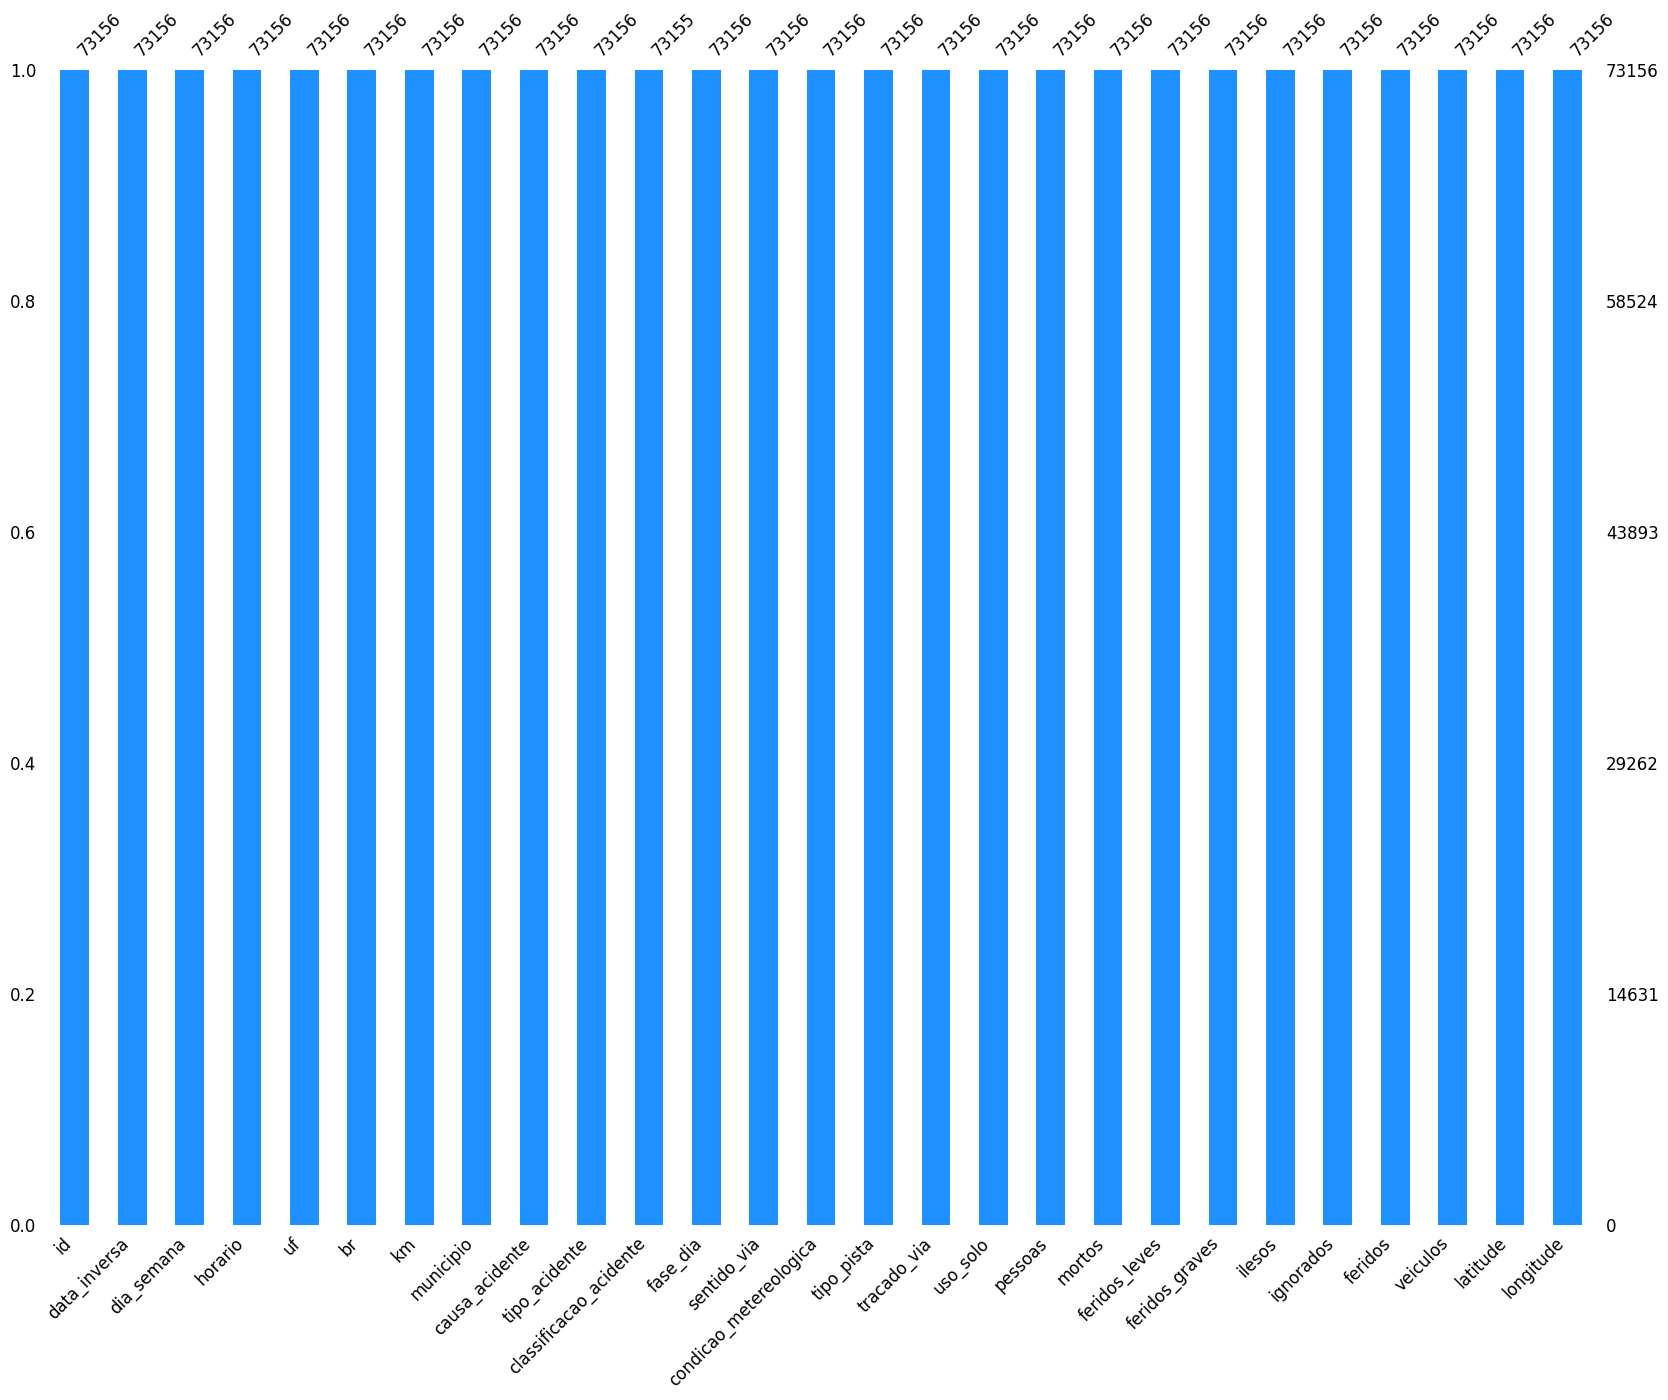

In [42]:
ms.bar(df_acidentes, color="dodgerblue",  figsize=(20,15), fontsize=12)

<Axes: >

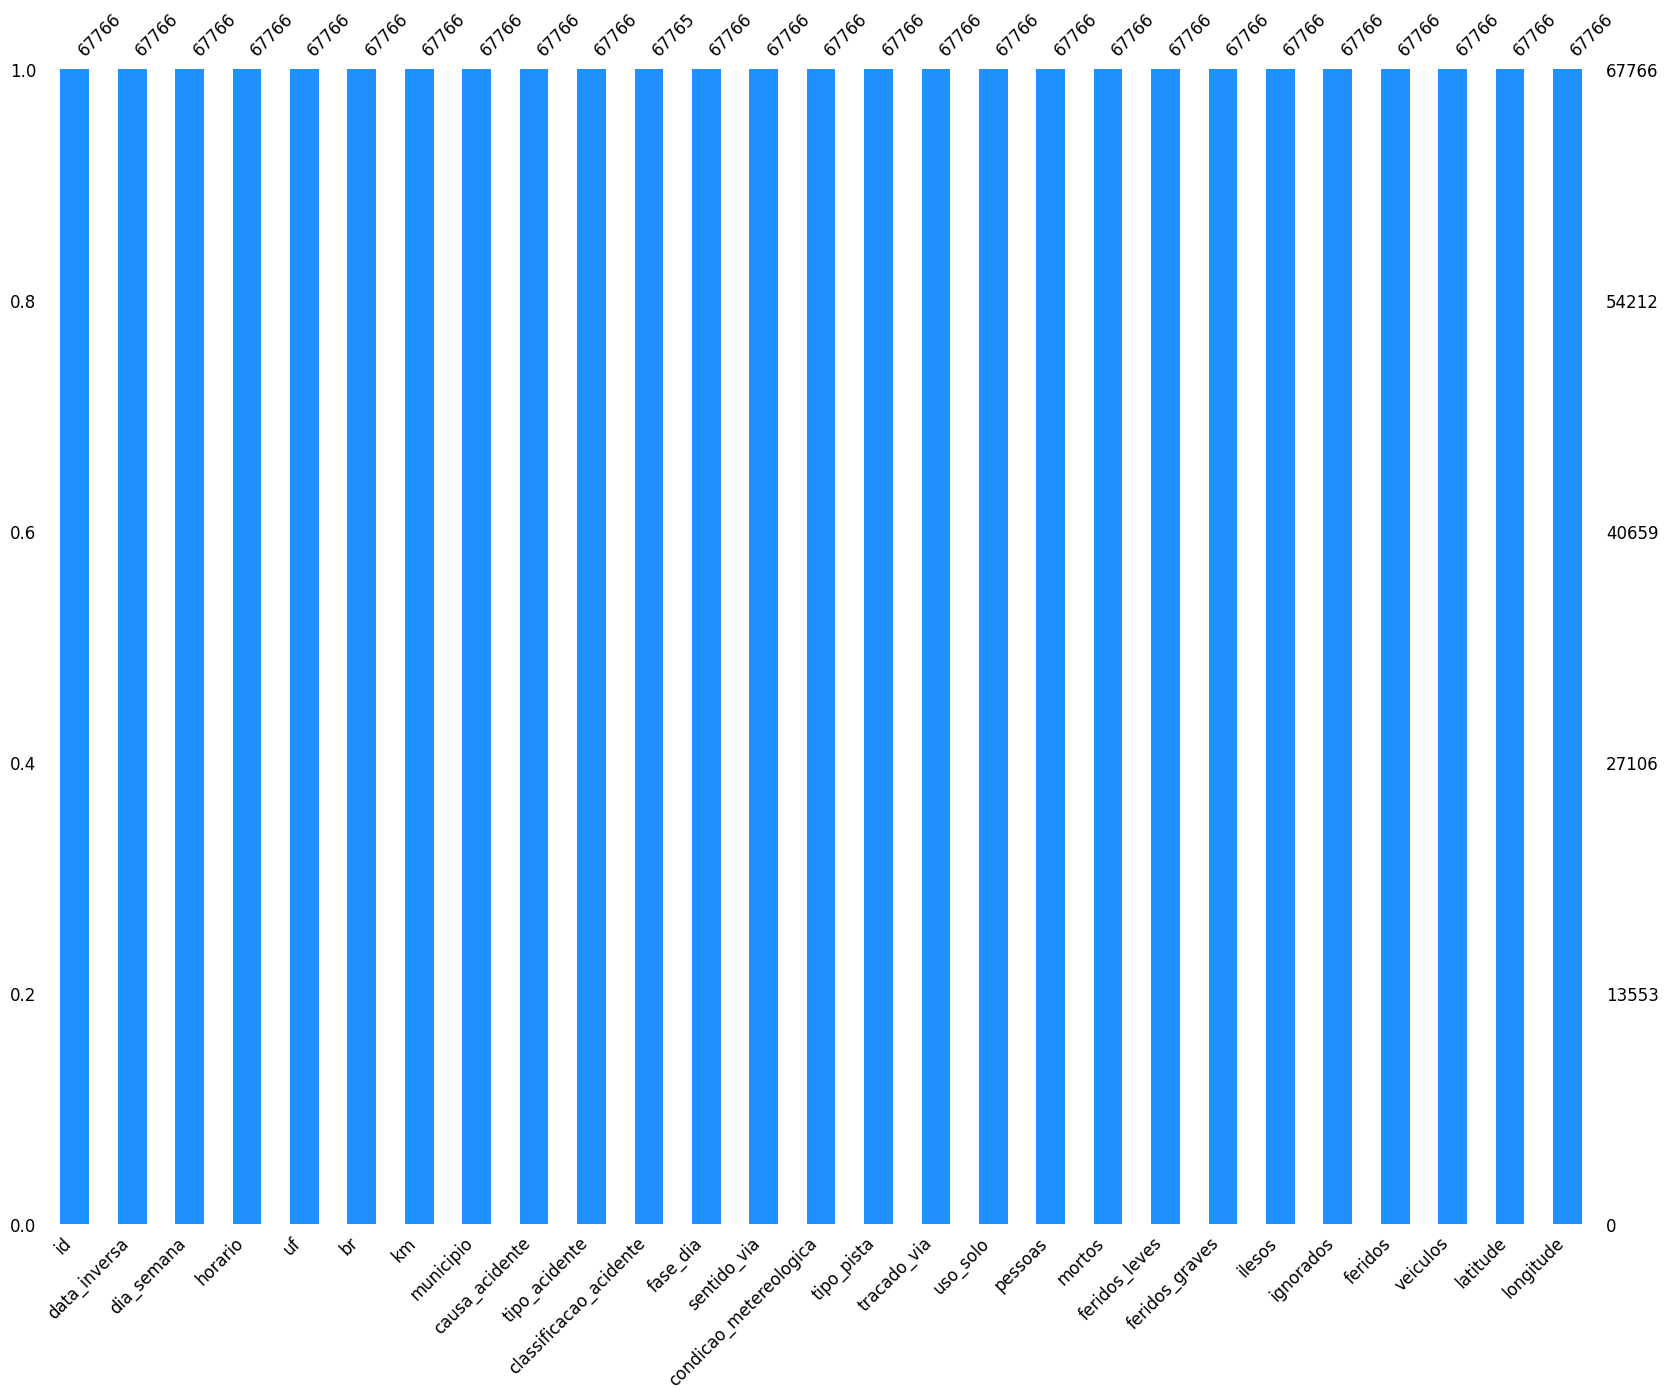

In [43]:
ms.bar(df_acidentes_2023, color="dodgerblue",  figsize=(20,15), fontsize=12)

O dataframe com as informações de 2024, não possui registros nulos.
>
Já o de 2023, possui 1 registro nulo no campo **classificacao_acidente**

In [44]:
# excluir registro NULL
df_acidentes_2023 = df_acidentes_2023.dropna()

In [45]:
df_acidentes = df_acidentes.dropna()

###**<font color=#4c60d6> 4.1.4 Criação de recursos**

Também conhecida como ***feature engineering***, a criação de recursos consiste em criar, a partir dos atributos originais, um conjunto de atributos que capture informações importantes.

> <font color=#4c60d6>**Concatenar informações**

In [46]:
df_acidentes = pd.concat([df_acidentes, df_acidentes_2023],sort=False, ignore_index=True)

> <font color=#4c60d6>**Campo data e hora**

In [47]:
# Dados 2024 e 2023
df_acidentes['data_hora'] = df_acidentes['data_inversa'].map(str) + ' ' + df_acidentes['horario']
df_acidentes['data_hora'] = pd.to_datetime(df_acidentes['data_hora'])
df_acidentes['ano'] = df_acidentes['data_hora'].dt.year
df_acidentes['mes'] = df_acidentes['data_hora'].dt.month
df_acidentes['hora'] = df_acidentes['data_hora'].dt.hour
df_acidentes['ano_mes'] = df_acidentes['data_hora'].dt.strftime('%Y-%m')
df_acidentes['semana'] = df_acidentes['data_hora'].dt.weekday
#o método weekday() devolve o dia da semana como um número inteiro onde a segunda-feira é indexada como 0 e o domingo como 6


In [48]:
# Mes em caracter
df_acidentes['mes_char'] = df_acidentes['mes']

dic_mes = {
1: 'Janeiro',
2: 'Fevereiro',
3: 'Março',
4: 'Abril',
5: 'Maio',
6: 'Junho',
7: 'Julho',
8: 'Agosto',
9: 'Setembro',
10: 'Outubro',
11: 'Novembro',
12: 'Dezembro'}

# Fazer o replace nos atributos conforme o dicionario
df_acidentes = df_acidentes.replace({
    'mes_char' : dic_mes
})

In [49]:
#quantidade de acidentes por ano
por_ano = df_acidentes[['ano', 'id']]
plt_por_ano = por_ano.groupby(["ano"]).count().reset_index()
plt_por_ano

,ano,id
0,2023,67765
1,2024,73155


> <font color=#4c60d6>**Atributo sinistro**

O dataframe registra 1 acidente (sinistro) por tupla, sendo assim, criaremos o atributo **sinistro**.

In [50]:
df_acidentes["sinistro"] = 1

In [51]:
df_acidentes.groupby(["ano"])['sinistro'].sum().reset_index()

,ano,sinistro
0,2023,67765
1,2024,73155


> <font color=#4c60d6>**Atributo Região**

In [52]:
# Left Join entre a Fato e a dimensão
df_acidentes = pd.merge(df_acidentes, tb_regiao, left_on=['uf'], right_on=['uf'], how='left')

###**<font color=#4c60d6> 4.1.5 Redução da dimensionalidade**

####**<font color=#4c60d6> Agregação**

Também pode ser considerada uma técnica de redução de dimensionalidade, pois reduz o número de colunas e linhas do dataset.
>
Vamos criar um dataset agregado para comparar o ano de análise com o ano anterior.
>
Assim, será possivel fazer analises comparativas mais rápidas, e ter um dataset menor para usar no Github e Streamlit.

In [53]:
df_hs_acidentes = df_acidentes[["uf","br","causa_acidente","tipo_acidente","classificacao_acidente",
                                        "condicao_metereologica","fase_dia","ano","mes","ano_mes","semana",
                                        "uf_nome","regiao",'sinistro','pessoas','mortos', 'feridos_leves', 'feridos_graves', 'ilesos', 'ignorados', 'veiculos']]


In [54]:
df_hs_acidentes = df_hs_acidentes.groupby(["uf","br","causa_acidente","tipo_acidente","classificacao_acidente",
                                        "condicao_metereologica","fase_dia","ano","mes","ano_mes","semana",
                                        "uf_nome","regiao"]).sum(['sinistro','pessoas','mortos', 'feridos_leves', 'feridos_graves', 'ilesos', 'ignorados', 'veiculos']).reset_index()



In [55]:
df_hs_acidentes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 136852 entries, 0 to 136851
Data columns (total 21 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   uf                      136852 non-null  object
 1   br                      136852 non-null  int64 
 2   causa_acidente          136852 non-null  object
 3   tipo_acidente           136852 non-null  object
 4   classificacao_acidente  136852 non-null  object
 5   condicao_metereologica  136852 non-null  object
 6   fase_dia                136852 non-null  object
 7   ano                     136852 non-null  int32 
 8   mes                     136852 non-null  int32 
 9   ano_mes                 136852 non-null  object
 10  semana                  136852 non-null  int32 
 11  uf_nome                 136852 non-null  object
 12  regiao                  136852 non-null  object
 13  sinistro                136852 non-null  int64 
 14  pessoas                 136852 non-n

#**<font color=#4c60d6 size="6"> 4.2 Pré-Processamento de dados DataFrame: Pessoas Envolvidas**

####**<font color=#4c60d6> 4.2.1 Duplicidade de registros**

In [56]:
df_pessoas.duplicated(subset='id', keep='first').sum()

np.int64(123150)

Esse DataFrame detalha as pessoas de cada registro de sinistro, sendo assim, teremos tantas tuplas quanto a quantidade de pessoas envolvidas no sinistro.

Existe o atributo PESID, que é o ID da pessoa, porem essa pessoa pode se acidentar mais de uma vez no mesmo ano

In [57]:
df_pessoas.duplicated(subset='pesid', keep='first').sum()

np.int64(17191)

Sendo assim, somente um analista de negócio para definir qual seria a chave única desse DataFrame.

####**<font color=#4c60d6> 4.2.2 Redundâncias**

In [58]:
df_pessoas.drop([
              'pesid', 'km', 'municipio', 'sentido_via', 'condicao_metereologica', 'tipo_pista',
              'tracado_via', 'uso_solo', 'id_veiculo', 'marca', 'ano_fabricacao_veiculo', 'regional',
               'delegacia', 'uop','longitude', 'latitude'
             ], axis=1, inplace= True)

####**<font color=#4c60d6> 4.2.3 Outliers**

Vamos tartar o atributo **IDADE**, que apresentou outliers, no capitulo "3.2.2 Distribuição dos atributos".
>
Primeiro um grande volume de idade igua a ZERO, poderiamo assumir que poderiam ser bebês com menos de 1 ano, mas muitos estão com o atributo "tipo_envolvido" preenchido como CONDUTOR, o que demonstra um erro no preenchimento do sinistro.

In [59]:
verifica_idades = df_pessoas[(df_pessoas['idade'] == 0)].groupby(["tipo_envolvido","idade"], dropna=False)['id'].count().reset_index()
(verifica_idades.sort_values(by="id", ascending=False )).head(10)

,tipo_envolvido,idade,id
5,NaN,0,17192
1,Condutor,0,10332
2,Passageiro,0,3271
4,Testemunha,0,3098
3,Pedestre,0,589
0,Cavaleiro,0,9


Tendo em vista que isso é um projeto acadêmico, e não temos a oportunidade de perguntar para um especialista o que regra aplicar, vou me basear no Anuário de 2023, onde foi criado faixa horarias entre 0 e 100.
>
Por decisão, vou tratar as IDADES igual a ZERO da seguinte maneira:
>
- Se o tipo envolvido for "Condutor", atribuir um valor aleátorio entre as 10 maiores idades do DataFrame.
>
Caso contrário, seguir com a idade inconsistente.

Verificando as 10 maiores ocorrências de idade:

In [60]:
# Verificar maior frequencia de idades, limitadas a 10
verifica_idades = df_pessoas[(df_pessoas['idade'] >= 0)].groupby(["idade"])['id'].count().reset_index()
(verifica_idades.sort_values(by="id", ascending=False )).head(10)

,idade,id
0,0,34491
36,36,4063
29,29,4061
27,27,4036
35,35,4023
25,25,3990
42,42,3976
38,38,3973
30,30,3959
28,28,3948


Sendo assim, iremos atribuir um valor aleatório entre 25 e 42 anos.
>
Vou criar um laço para percorrer todas a tuplas e conferir se atende aos critérios definidos anteriromente.

In [61]:
#Vamos criar o atributo "idade_tratada"
df_pessoas['idade_tratada'] = df_pessoas['idade']

In [62]:
#Para percorrer cada registro do dataframe, criamos o laço de repetição FOR
#Dentro desse laço, uma condição de IF, para testar o atributo.


for i in range(len(df_pessoas)):
  if ((df_pessoas['idade'][i] == 0) & (df_pessoas['tipo_envolvido'][i] == 'Condutor')) :
    df_pessoas['idade_tratada'][i] = (randint(25,42))
  else:
    df_pessoas['idade_tratada'][i] = df_pessoas['idade'][i]

In [63]:
#validando
val_idades = df_pessoas[(df_pessoas['idade_tratada'] == 0)].groupby(["tipo_envolvido","idade_tratada"], dropna=False)['id'].count().reset_index()
(val_idades.sort_values(by="id", ascending=False )).head(10)

,tipo_envolvido,idade_tratada,id
4,NaN,0,17192
1,Passageiro,0,3271
3,Testemunha,0,3098
2,Pedestre,0,589
0,Cavaleiro,0,9




---



Idades maiores que 100

In [64]:
# Verificar idades inconsistentes
# Cria um dataframe com idade > 100, agrupando e contando quantas vezes aparecem no dataframe
verifica_idade = df_pessoas[(df_pessoas['idade'] > 100)].groupby(["idade"])['id'].count().reset_index()
verifica_idade.sort_values(by="idade", ascending=True )

,idade,id
0,102,1
1,106,1
2,114,1
3,115,1
4,123,2
5,124,65
6,126,1
7,328,1
8,330,1
9,524,12


Baseado no anuário de 2023, onde foi considerado apenas as idades até 100 anos, vou aplicar a mesma lógica anterior para distribuir melhor, utilizando um RANGE de 1 a 100.

In [65]:
for i in range(len(df_pessoas)):
  if ((df_pessoas['idade'][i] > 100)) :
    df_pessoas['idade_tratada'][i] = (randint(1,100))
  else:
    df_pessoas['idade_tratada'][i] = df_pessoas['idade'][i]

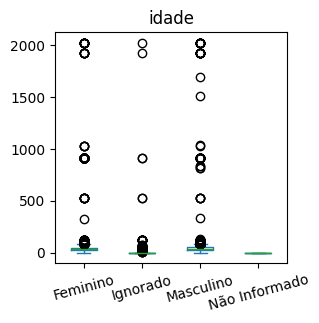

In [66]:
df_pessoas.plot.box(column="idade", by='sexo', figsize=(3, 3), rot=15)
plt.show()

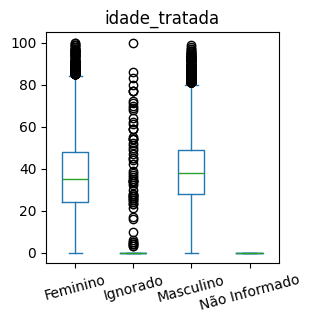

In [67]:
df_pessoas.plot.box(column="idade_tratada", by='sexo', figsize=(3, 3), rot=15)
plt.show()

In [68]:
#Excluindo a redundância do atributo idade, ficando apenas com o idade_tratada
df_pessoas.drop(['idade'],	axis=1, inplace = True)

####**<font color=#4c60d6> 4.2.3 Tratamento de Missings**

Nessa etapa iremos tratar dos atributos que apresentaram valores de "Não Informado" e "missings".

<Axes: >

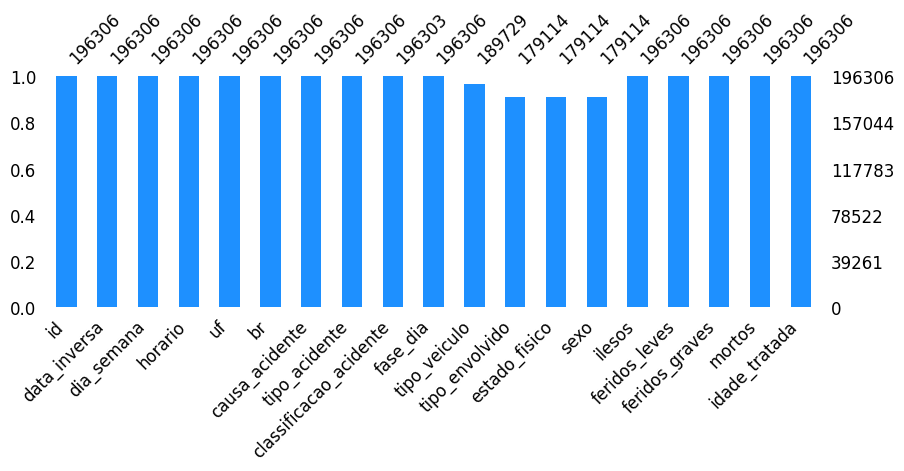

In [69]:
ms.bar(df_pessoas, color="dodgerblue",  figsize=(10,3), fontsize=12)

Os atributos com mais registros null/NaN são: tipo_envolvido, estado_fisico e sexo

In [70]:
df_null = (pd.DataFrame(df_pessoas.isnull().sum())).reset_index()
df_null.sort_values(by=0, ascending=False ).head(10)

,index,0
11,tipo_envolvido,17192
13,sexo,17192
12,estado_fisico,17192
10,tipo_veiculo,6577
8,classificacao_acidente,3
0,id,0
1,data_inversa,0
2,dia_semana,0
6,causa_acidente,0
3,horario,0


><font color=#4c60d6>Estado da vítima

Vamos tratar esse atributo da seguinte maneira.
>
Substituir os registros NaN por "Não informado"
>
Preencher o atributo estado_fisico, baseado na classificacao_acidente, dessa forma:
>
Com Vítimas Feridas = Lesões Leves
>
Sem Vítimas = Ileso
>
Com Vítimas Fatais = Óbito
>
Além de quantificar na métrica apropriada com o valor 1.

In [71]:
df_pessoas.estado_fisico.value_counts(dropna=False) #quantidade

,count
estado_fisico,
Ileso,76675
Lesões Leves,64182
Lesões Graves,20344
NaN,17192
Não Informado,11753
Óbito,6160


In [72]:
# substituindo os NaN por 'Não Informado'
df_pessoas['estado_fisico'].fillna('Não Informado', inplace=True)

In [73]:
aux_estado_fisico_ant = df_pessoas.estado_fisico.value_counts(dropna=False) #quantidade
df_pessoas.estado_fisico.value_counts(dropna=False) #quantidade

,count
estado_fisico,
Ileso,76675
Lesões Leves,64182
Não Informado,28945
Lesões Graves,20344
Óbito,6160


In [74]:
# Primeiro preencher as métricas quantificando com o valor 1
df_pessoas.loc[((df_pessoas.estado_fisico=='Não Informado')  # 1ª condição
                    & (df_pessoas.classificacao_acidente=='Sem Vítimas')), # 2ª condição
                   'ilesos']=1 # valor

df_pessoas.loc[((df_pessoas.estado_fisico=='Não Informado') # 1ª condição
                    & (df_pessoas.classificacao_acidente=='Com Vítimas Feridas')), # 2ª condição
                   'feridos_leves']=1 # valor

df_pessoas.loc[((df_pessoas.estado_fisico=='Não Informado') # 1ª condição
                    & (df_pessoas.classificacao_acidente=='Com Vítimas Fatais')), # 2ª condição
                   'mortos']=1 # valor

# Alterar o valor do atributo estado_fisico
df_pessoas.loc[((df_pessoas.estado_fisico=='Não Informado')  # 1ª condição
                    & (df_pessoas.classificacao_acidente=='Sem Vítimas')), # 2ª condição
                   'estado_fisico']='Ileso' # valor

df_pessoas.loc[((df_pessoas.estado_fisico=='Não Informado') # 1ª condição
                    & (df_pessoas.classificacao_acidente=='Com Vítimas Feridas')), # 2ª condição
                   'estado_fisico']='Lesões Leves' # valor

df_pessoas.loc[((df_pessoas.estado_fisico=='Não Informado') # 1ª condição
                    & (df_pessoas.classificacao_acidente=='Com Vítimas Fatais')), # 2ª condição
                   'estado_fisico']='Óbito' # valor


In [75]:
aux_estado_fisico_dep = df_pessoas.estado_fisico.value_counts(dropna=False) #quantidade
df_pessoas.estado_fisico.value_counts(dropna=False) #quantidade

,count
estado_fisico,
Ileso,83414
Lesões Leves,82482
Lesões Graves,20344
Óbito,10065
Não Informado,1


In [76]:
result_nan =  pd.merge(aux_estado_fisico_ant, aux_estado_fisico_dep, left_on=['estado_fisico'], right_on=['estado_fisico'], how='left')
result_nan["diferenca"] = result_nan["count_y"] - result_nan["count_x"]
result_nan

,count_x,count_y,diferenca
estado_fisico,,,
Ileso,76675,83414,6739
Lesões Leves,64182,82482,18300
Não Informado,28945,1,-28944
Lesões Graves,20344,20344,0
Óbito,6160,10065,3905


><font color=#4c60d6>Tipo Envolvido

In [77]:
df_pessoas.tipo_envolvido.value_counts(dropna=False) #quantidade

,count
tipo_envolvido,
Condutor,122425
Passageiro,50112
NaN,17192
Pedestre,3439
Testemunha,3098
Cavaleiro,40


In [78]:
#percentual da distribuição
(df_pessoas.tipo_envolvido.value_counts(dropna=False, normalize=True)*100).round(1)

,proportion
tipo_envolvido,
Condutor,62.4
Passageiro,25.5
NaN,8.8
Pedestre,1.8
Testemunha,1.6
Cavaleiro,0.0


Para esse atributo não teríamos como tentar recuperar o preenchimento dos registros NaN, sendo assim, iremos deixar dessa maneira para demontrar que cerca de 9% dos registros não foram cadastrados de maneira correta.

><font color=#4c60d6>Sexo

Agora vou tratar o atributo sexo, pois foi verificado os valores de "Não Informado" e "Ignorado".
>
Vamos utilizar a distribuição de Bernoulli, nome dado em homenagem ao cientista suíço Jakob Bernoulli.
>
É a distribuição discreta de espaço amostral {0, 1}, que tem valor 1 com a probabilidade de sucesso p e valor 0 com a probabilidade de falha.

In [79]:
# Verificando o percentual da distribuição
df_pessoas.sexo.value_counts(dropna=False, normalize=True)

,proportion
sexo,
Masculino,0.635386
Feminino,0.214543
NaN,0.087578
Não Informado,0.059871
Ignorado,0.002623


Como temos cerca de 63% de vitimas conhecidas, são do sexo Masculino, iremos utilizar o parâmetro de sucesso P = 0.63.

In [80]:
# substituindo os NaN por 'Não Informado'
df_pessoas['sexo'].fillna('Não Informado', inplace=True)

In [81]:
#Vamos criar o atributo "sexo_tratado"
df_pessoas['sexo_tratado'] = df_pessoas['sexo']

In [82]:
#Para percorrer cada registro do dataframe, criamos o laço de repetição FOR
#Dentro desse laço, uma condição de IF, para testar o atributo.
#Caso seja Ignorado ou Não Informado, aplicar Bernoulli, se não, preenche com o sexo do proprio registro

for i in range(len(df_pessoas)):
  if ((df_pessoas['sexo'][i] == 'Ignorado') | (df_pessoas['sexo'][i] == 'Não Informado')) :
    df_pessoas['sexo_tratado'][i] = (bernoulli.rvs(size=1,p=0.63)).astype(int)
  else:
    df_pessoas['sexo_tratado'][i] = df_pessoas['sexo'][i]

Por ser uma distribuição binária, seu resultado é 1 ou 0, sendo assim, devemos substituir 1 por Masculino e 0 para Feminino.

In [83]:
df_pessoas.loc[df_pessoas.sexo_tratado==1,'sexo_tratado']='Masculino'
df_pessoas.loc[df_pessoas.sexo_tratado==0,'sexo_tratado']='Feminino'

In [84]:
#percentual da distribuição
(df_pessoas.sexo_tratado.value_counts(dropna=False, normalize=True)*100).round(1)

,proportion
sexo_tratado,
Masculino,72.9
Feminino,27.1


In [85]:
#Excluindo a redundância do atributo sexo, ficando apenas com o sexo_tratado
df_pessoas.drop(['sexo'],	axis=1, inplace = True)

><font color=#4c60d6>Conclusão

<Axes: >

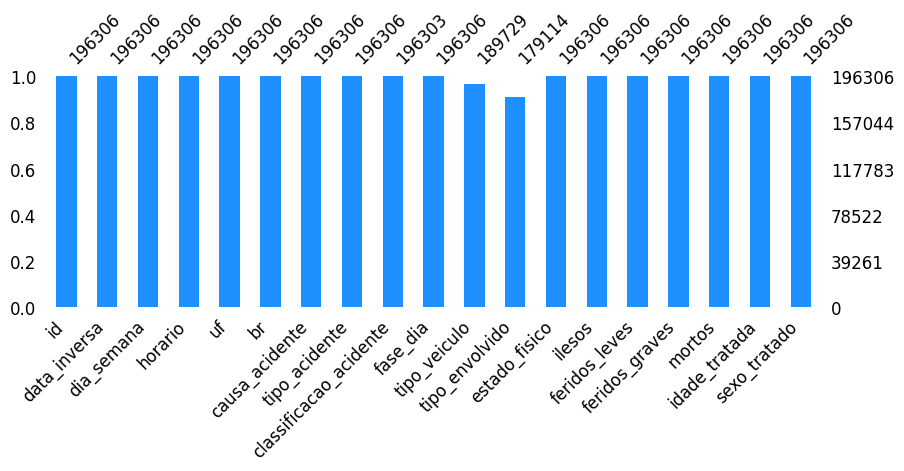

In [86]:
ms.bar(df_pessoas, color="dodgerblue",  figsize=(10,3), fontsize=12)

###**<font color=#4c60d6> 4.2.4 Criação de recursos**

Também conhecida como ***feature engineering***, a criação de recursos consiste em criar, a partir dos atributos originais, um conjunto de atributos que capture informações importantes.

> <font color=#4c60d6>**Campo data e hora**

In [87]:
# Dados 2024 e 2023
df_pessoas['data_hora'] = df_pessoas['data_inversa'].map(str) + ' ' + df_pessoas['horario']
df_pessoas['data_hora'] = pd.to_datetime(df_pessoas['data_hora'])
df_pessoas['ano'] = df_pessoas['data_hora'].dt.year
df_pessoas['mes'] = df_pessoas['data_hora'].dt.month
df_pessoas['hora'] = df_pessoas['data_hora'].dt.hour
df_pessoas['ano_mes'] = df_pessoas['data_hora'].dt.strftime('%Y-%m')
df_pessoas['semana'] = df_pessoas['data_hora'].dt.weekday

In [88]:
# Mes em caracter
df_pessoas['mes_char'] = df_pessoas['mes']

dic_mes = {
1: 'Janeiro',
2: 'Fevereiro',
3: 'Março',
4: 'Abril',
5: 'Maio',
6: 'Junho',
7: 'Julho',
8: 'Agosto',
9: 'Setembro',
10: 'Outubro',
11: 'Novembro',
12: 'Dezembro'}

# Fazer o replace nos atributos conforme o dicionario
df_pessoas = df_pessoas.replace({
    'mes_char' : dic_mes
})

> <font color=#4c60d6>**Atributo Região**

In [89]:
# Left Join entre a Fato e a dimensão
df_pessoas = pd.merge(df_pessoas, tb_regiao, left_on=['uf'], right_on=['uf'], how='left')

> <font color=#4c60d6>**Faixa de idade**

Para criar o atributo faixa_idade, teremos que dar nomes as classes e definir o intervalo de cada.
>
Iremos utilizar como referência as faixas utilizadas no anuário de 2023.
>
0 - 16, 17-24, 25- 34, 35-44, 45-64, 65-99
>
Como tratamos as idades com valores maiores que 100, irei modificar a última faixa e incluir 100 anos.

In [90]:
# Definindo o nome das faixa
faixa = ['0 a 16','17 a 24','25 a 34','35 a 44','45 a 64', '65 a 100']

# Definindo o intervalo das faixas
intervalo = [-1,16,24,34,44,64,100]

classes = pd.cut(x=df_pessoas.idade_tratada, labels=faixa, bins=intervalo)
df_pessoas['faixa_idade'] = classes

> <font color=#4c60d6>**Atributo Pessoas**

O Datrafame acidentes, detalha o estado de cada vítima envolvida no acidente.
>
Dessa maneira, vamos criar atributo pessoas, que irá somar a quantidade de pessoas envolvidas, facilitando as análises agrupadas.

In [91]:
#Criando o atributo somando o estado das vítimas
df_pessoas['pessoas'] = df_pessoas['ilesos'] + df_pessoas['feridos_leves'] +	df_pessoas['feridos_graves'] +	df_pessoas['mortos']

> <font color=#4c60d6>**Atributo Classe Veículo**

Vamos criar um atributo, que classifica o tipo de veículo por classe.

In [92]:
df_pessoas['classe_veiculos'] = df_pessoas['tipo_veiculo']
df_pessoas['classe_veiculos'] = df_pessoas.classe_veiculos.str.replace('Bicicleta','Motocicleta')
df_pessoas['classe_veiculos'] = df_pessoas.classe_veiculos.str.replace('Motocicleta','Motocicleta')
df_pessoas['classe_veiculos'] = df_pessoas.classe_veiculos.str.replace('Motoneta','Motocicleta')
df_pessoas['classe_veiculos'] = df_pessoas.classe_veiculos.str.replace('Triciclo','Motocicleta')
df_pessoas['classe_veiculos'] = df_pessoas.classe_veiculos.str.replace('Ciclomotor','Motocicleta')
df_pessoas['classe_veiculos'] = df_pessoas.classe_veiculos.str.replace('Automóvel','Automóvel')
df_pessoas['classe_veiculos'] = df_pessoas.classe_veiculos.str.replace('Caminhonete','Automóvel')
df_pessoas['classe_veiculos'] = df_pessoas.classe_veiculos.str.replace('Camioneta','Automóvel')
df_pessoas['classe_veiculos'] = df_pessoas.classe_veiculos.str.replace('Utilitário','Automóvel')
df_pessoas['classe_veiculos'] = df_pessoas.classe_veiculos.str.replace('Caminhão','Caminhão')
df_pessoas['classe_veiculos'] = df_pessoas.classe_veiculos.str.replace('Caminhão-trator','Caminhão')
df_pessoas['classe_veiculos'] = df_pessoas.classe_veiculos.str.replace('Micro-ônibus','Ônibus')
df_pessoas['classe_veiculos'] = df_pessoas.classe_veiculos.str.replace('Ônibus','Ônibus')
df_pessoas['classe_veiculos'] = df_pessoas.classe_veiculos.str.replace('Carro de mão','Outros')
df_pessoas['classe_veiculos'] = df_pessoas.classe_veiculos.str.replace('Carroça-charrete','Outros')
df_pessoas['classe_veiculos'] = df_pessoas.classe_veiculos.str.replace('Chassi-plataforma','Outros')
df_pessoas['classe_veiculos'] = df_pessoas.classe_veiculos.str.replace('Quadriciclo','Outros')
df_pessoas['classe_veiculos'] = df_pessoas.classe_veiculos.str.replace('Reboque','Caminhão')
df_pessoas['classe_veiculos'] = df_pessoas.classe_veiculos.str.replace('Semireboque','Caminhão')
df_pessoas['classe_veiculos'] = df_pessoas.classe_veiculos.str.replace('Trator de esteira','Outros')
df_pessoas['classe_veiculos'] = df_pessoas.classe_veiculos.str.replace('Trator de rodas','Outros')
df_pessoas['classe_veiculos'] = df_pessoas.classe_veiculos.str.replace('Trator misto','Outros')
df_pessoas['classe_veiculos'] = df_pessoas.classe_veiculos.str.replace('Trem-bonde','Outros')


In [93]:
#Verificando a classe criada
df_pessoas.groupby(['classe_veiculos','tipo_veiculo'])['pessoas'].sum()

classe_veiculos  tipo_veiculo     
Automóvel        Automóvel            69998
                 Caminhonete          16415
                 Camioneta             4917
                 Utilitário            3243
Caminhão         Caminhão             11159
                 Caminhão-trator      13224
                 Reboque               1592
                 Semireboque          15244
Motocicleta      Bicicleta             1924
                 Ciclomotor             392
                 Motocicleta          37479
                 Motoneta              3950
                 Triciclo                30
Motor-casa       Motor-casa              32
Outros           Carro de mão             5
                 Carroça-charrete        61
                 Chassi-plataforma        6
                 Outros                 395
                 Quadriciclo              2
                 Trator de esteira        6
                 Trator de rodas         67
                 Trator misto             3
                 Trem-bonde               3
Ônibus           Micro-ônibus          1509
                 Ônibus                8072
Name: pessoas, dtype: int64

In [94]:
# excluir algumas colunas que usamos como apoio para criar atributos e que não iremos mais usar
df_pessoas.drop([ 'id','data_inversa','data_hora'],
		axis=1, inplace = True)

#**<font color=#4c60d6 size="6"> 5. Export**

Agora iremos exportar o dataset em CSV, para usarmos no Streamlit

> <font color=#4c60d6>**Dataset histórico**

In [95]:
from shutil import copyfileobj
import bz2

# Exportar para csv
df_hs_acidentes.to_csv('df_hs_acidentes.csv', index=False)

# compactar arquivo com nivel de compressão máxima
with open('df_hs_acidentes.csv', 'rb') as input:
    with bz2.BZ2File('df_hs_acidentes.csv.bz2', 'wb', compresslevel=9) as output:
        copyfileobj(input, output)

> <font color=#4c60d6>**Dataset 2024**

In [96]:
df_acidentes_2024 = df_acidentes.query('ano == 2024')

In [97]:
# Exportar para csv
df_acidentes_2024.to_csv('df_acidentes_2024.csv', index=False)

# compactar arquivo com nivel de compressão máxima
with open('df_acidentes_2024.csv', 'rb') as input:
    with bz2.BZ2File('df_acidentes_2024.csv.bz2', 'wb', compresslevel=9) as output:
        copyfileobj(input, output)

> <font color=#4c60d6>**Dataset Pessoas Envolvidas**

In [102]:
df_pessoas_agr = df_pessoas[['ano','mes','hora','ano_mes','semana', 'dia_semana', 'mes_char','uf','uf_nome','regiao','br',
                                    'causa_acidente','tipo_acidente','classificacao_acidente','fase_dia',
                                    'tipo_veiculo', 'classe_veiculos', 'tipo_envolvido', 'estado_fisico','idade_tratada','faixa_idade',
                                     'pessoas','ilesos','feridos_leves','feridos_graves','mortos']]

In [104]:
# Exportar para csv
df_pessoas_agr.to_csv('df_pessoas.csv', index=False)

# compactar arquivo com nivel de compressão máxima
with open('df_pessoas.csv', 'rb') as input:
    with bz2.BZ2File('df_pessoas.csv.bz2', 'wb', compresslevel=9) as output:
        copyfileobj(input, output)